<a id='top'></a>
# How to slice and dice the data
Below are a series of examples on how to slice and dice the data that is stored in the *.sqlite* file generated by the [MorningStar.com](https://www.morningstar.com) scraper. 

##### NOTE: 
- The data used to generate the codes below comes from the *.sqlite* that is generated by the scraper once it has been installed and ran locally on your machine. See the [README]() for instructions on how to run install and run the scraper.
- Navigation links as the ones in the list of content below as well as other links throught this document will only work if you are using [Jupyter](https://jupyter.org/) to view this document.


**Content** 

1. [Required modules and matplotlib backend](#modules)
1. [Creating a master (bridge table) DataFrame instance using the DataFrames class](#master)
1. [Creating DataFrame instances with the dataframes methods](#methods)
1. [Statistical values on the MorningStar data downloaded](#stats)
1. [Applying various criteria to filter common stocks](#value) *(in progress)*
1. [Additional sample / test code](#additional) *(in progress)*

<a id="modules"></a>
## Required modules and matplotlib backend

In [171]:
%matplotlib notebook

In [172]:
import matplotlib.pyplot as plt
import matplotlib

In [173]:
from importlib import reload
import pandas as pd
import numpy as np

# Import dataframes module from project folder.
# This module contains a class that reads the database tables and assigns the data to pandas.DataFrame objects
import dataframes
reload(dataframes) #reload if changes have been made to module file

<module 'dataframes' from '/home/cbrandao/lib/python/msTables/dataframes.py'>

[return to the top](#top)
<a id="master"></a>
## Creating a master DataFrame instance using the dataframes class
The DataFrames class is part of the [dataframes module](dataframes.py)

In [174]:
db_file_name = 'mstables2' # Change the file name here as needed
df = dataframes.DataFrames('db/{}.sqlite'.format(db_file_name))

Creating intial DataFrames from file db/mstables2.sqlite...
Creating DataFrame 'colheaders' ...
Creating DataFrame 'timerefs' ...
Creating DataFrame 'urls' ...
Creating DataFrame 'securitytypes' ...
Creating DataFrame 'tickers' ...
Creating DataFrame 'sectors' ...
Creating DataFrame 'industries' ...
Creating DataFrame 'stockstyles' ...
Creating DataFrame 'exchanges' ...
Creating DataFrame 'countries' ...
Creating DataFrame 'companies' ...
Creating DataFrame 'currencies' ...
Creating DataFrame 'stocktypes' ...
Creating DataFrame 'master' ...
Initial DataFrames created.


### Creating Master DataFrame instance from reference tables
By merging `df.master` (*Master* bridge table) with other reference tables (e.g. `df.tickers`, `df.exchanges`, etc.)
##### DataFrame Instance

In [175]:
# Merge Tables
df_master0 = (df.master
# Ticker Symbols
 .merge(df.tickers, left_on='ticker_id', right_on='id').drop(['id'], axis=1)
# Company / Security Name
 .merge(df.companies, left_on='company_id', right_on='id').drop(['id', 'company_id'], axis=1)
# Exchanges
 .merge(df.exchanges, left_on='exchange_id', right_on='id').drop(['id'], axis=1)
# Industries
 .merge(df.industries, left_on='industry_id', right_on='id').drop(['id', 'industry_id'], axis=1)
# Sectors
 .merge(df.sectors, left_on='sector_id', right_on='id').drop(['id', 'sector_id'], axis=1)
# Countries
 .merge(df.countries, left_on='country_id', right_on='id').drop(['id', 'country_id'], axis=1)
# Security Types
 .merge(df.securitytypes, left_on='security_type_id', right_on='id').drop(['id', 'security_type_id'], axis=1)
# Stock Types
 .merge(df.stocktypes, left_on='stock_type_id', right_on='id').drop(['id', 'stock_type_id'], axis=1)
# Stock Style Types
 .merge(df.styles, left_on='style_id', right_on='id').drop(['id', 'style_id'], axis=1)
# Quote Header Info
 .merge(df.quoteheader(), on=['ticker_id', 'exchange_id']).rename(columns={'fpe':'Forward_PE'})
# Currency
 .merge(df.currencies, left_on='currency_id', right_on='id').drop(['id', 'currency_id'], axis=1)
# Fiscal Year End
 .merge(df.timerefs, left_on='fyend_id', right_on='id').drop(['fyend_id'], axis=1)
             .rename(columns={'dates':'fy_end'})
# Updated Date
 .merge(df.timerefs, left_on='update_date_id', right_on='id').drop(['update_date_id'], axis=1)
             .rename(columns={'dates':'updated_date'})
)

# Change date columns to TimeFrames
df_master0['fy_end'] = pd.to_datetime(df_master0['fy_end'])
df_master0['updated_date'] = pd.to_datetime(df_master0['updated_date'])

# Create df_master and apply filters
df_master = df_master0.copy()

df_master[['lastprice', 'day_hi', 'day_lo', '_52wk_hi', '_52wk_lo', 'yield', 'aprvol', 'avevol']] = (
    df_master[['lastprice', 'day_hi', 'day_lo', '_52wk_hi', '_52wk_lo', 'yield', 'aprvol', 'avevol']]
    .fillna(value=0.0))

df_master = (df_master.where((df_master['openprice'] > 0.0) & (df_master['lastprice'] > 0.0))
             .dropna(axis=0, how='all'))

In [176]:
df_master.head()

,ticker_id,exchange_id,ticker,company,exchange,exchange_sym,industry,sector,country,country_c2,...,aprvol,avevol,Forward_PE,pb,ps,pc,currency,currency_code,fy_end,updated_date
0,1.0,374.0,OGCP,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,ARCX,REIT - Diversified,Real Estate,United States,US,...,11.0,3498.0,NaN,2.4,6.4,16.7,United States Dollar,USD,2019-12-31,2019-04-08
1,2.0,374.0,FISK,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,ARCX,REIT - Diversified,Real Estate,United States,US,...,1300.0,3014.0,NaN,2.4,6.4,16.8,United States Dollar,USD,2019-12-31,2019-04-08
2,3.0,374.0,ESBA,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,ARCX,REIT - Diversified,Real Estate,United States,US,...,4243.0,17288.0,NaN,2.4,6.4,16.8,United States Dollar,USD,2019-12-31,2019-04-08
3,19437.0,302.0,PSB,PS Business Parks Inc,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Diversified,Real Estate,United States,US,...,483944.0,90418.0,NaN,5.1,9.9,14.9,United States Dollar,USD,2019-12-31,2019-04-08
4,20371.0,302.0,STOR,STORE Capital Corp,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Diversified,Real Estate,United States,US,...,15000000.0,17000000.0,NaN,1.9,12.7,17.5,United States Dollar,USD,2019-12-31,2019-04-08


##### DataFrame Length

In [177]:
print('Master DataFrame contains {:,.0f} records.'.format(len(df_master)))

Master DataFrame contains 103,499 records.


##### DataFrame Columns

In [178]:
df_master.columns

Index(['ticker_id', 'exchange_id', 'ticker', 'company', 'exchange',
       'exchange_sym', 'industry', 'sector', 'country', 'country_c2',
       'country_c3', 'security_type_code', 'security_type', 'stock_type',
       'style', 'openprice', 'lastprice', 'day_hi', 'day_lo', '_52wk_hi',
       '_52wk_lo', 'yield', 'aprvol', 'avevol', 'Forward_PE', 'pb', 'ps', 'pc',
       'currency', 'currency_code', 'fy_end', 'updated_date'],
      dtype='object')

<br></br>
[return to the top](#top)
<a id='methods'></a>
## Creating DataFrame instances with dataframes methods
Class DataFrames from [dataframe.py](dataframe.py) contains the following methods that return a pd.DataFrame object for the specified database table:

- `quoteheader` - [MorningStar (MS) Quote Header](#quote)
- `valuation` - [MS Valuation table with Price Ratios (P/E, P/S, P/B, P/C) for the past 10 yrs](#val)
- `keyratios` - [MS Ratio - Key Financial Ratios & Values](#keyratios)
- `finhealth` - [MS Ratio - Financial Health](#finhealth)
- `profitability` - [MS Ratio - Profitability](#prof)
- `growth` - [MS Ratio - Growth](#growth)
- `cfhealth` - [MS Ratio - Cash Flow Health](#cfh)
- `efficiency` - [MS Ratio - Efficiency](#eff)
- `annualIS` - [MS Annual Income Statements](#isa)
- `quarterlyIS` - [MS Quarterly Income Statements](#isq)
- `annualBS` - [MS Annual Balance Sheets](#bsa)
- `quarterlyBS` - [MS Quarterly Balance Sheets](#bsq)
- `annualCF` - [MS Annual Cash Flow Statements](#cfa)
- `quarterlyCF` - [MS Quarterly Cash Flow Statements](#cfq)
- `pricehistory` - MSpricehistory

[return to the top](#top)
<a id='quote'></a>
### Quote Header 
##### DataFrame Instance

In [95]:
df_quote = df.quoteheader()

In [96]:
df_quote.head()

,ticker_id,exchange_id,openprice,lastprice,day_hi,day_lo,_52wk_hi,_52wk_lo,yield,aprvol,avevol,fpe,pb,ps,pc,currency_id
0,1,374,15.73,15.72,15.73,15.72,17.72,12.16,2.67,11.0,3498.0,NaN,2.4,6.4,16.7,104.0
1,2,374,15.75,15.77,15.78,15.73,17.68,13.68,2.66,1300.0,3014.0,NaN,2.4,6.4,16.8,104.0
2,3,374,15.76,15.71,15.76,15.63,17.79,11.99,2.67,4243.0,17288.0,NaN,2.4,6.4,16.8,104.0
3,4,482,96.19,95.9,96.48,95.35,115.11,87.87,1.25,192854.0,804691.0,19.8,3.3,3.9,20.1,104.0
4,5,1,0.00,0,0,0,0,0,NaN,184.0,184.0,NaN,NaN,NaN,NaN,104.0


##### DataFrame Length

In [97]:
print('DataFrame contains {:,.0f} records.'.format(len(df_quote)))

DataFrame contains 117,675 records.


<a id='val'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Price Ratios (P/E, P/S, P/B, P/C)
##### DataFrame Instance

In [136]:
df_vals = df.valuation().reset_index()

In [137]:
df_vals

,exchange_id,ticker_id,PE_2009,PE_2010,PE_2011,PE_2012,PE_2013,PE_2014,PE_2015,PE_2016,...,PC_2010,PC_2011,PC_2012,PC_2013,PC_2014,PC_2015,PC_2016,PC_2017,PC_2018,PC_TTM
0,374,1,NaN,NaN,NaN,NaN,NaN,18.6,69.0,57.8,...,NaN,NaN,NaN,48.3,-153.8,24.3,25.8,26.3,21.5,16.7
1,374,2,NaN,NaN,NaN,NaN,NaN,18.2,69.0,58.8,...,NaN,NaN,NaN,50.5,-151.5,24.3,26.2,26.4,20.3,16.8
2,374,3,NaN,NaN,NaN,NaN,NaN,18.3,69.4,58.8,...,NaN,NaN,NaN,48.3,-153.8,24.4,26.2,26.7,20.6,16.8
3,482,4,NaN,22.2,17.4,16.6,27.0,29.7,26.6,31.7,...,16.2,11.1,12.9,19.6,23.1,19.9,26.8,52.9,21.8,20.1
4,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.8,NaN,-0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,10,NaN,NaN,NaN,NaN,1.1,NaN,NaN,NaN,...,-0.8,-0.1,0.0,11.2,-0.4,0.0,0.0,NaN,NaN,NaN


##### DataFrame Length

In [138]:
print('DataFrame contains {:,.0f} records.'.format(len(df_vals)))

DataFrame contains 80,016 records.


##### DataFrame Columnns

In [139]:
df_vals.columns

Index(['exchange_id', 'ticker_id', 'PE_2009', 'PE_2010', 'PE_2011', 'PE_2012',
       'PE_2013', 'PE_2014', 'PE_2015', 'PE_2016', 'PE_2017', 'PE_2018',
       'PE_TTM', 'PS_2009', 'PS_2010', 'PS_2011', 'PS_2012', 'PS_2013',
       'PS_2014', 'PS_2015', 'PS_2016', 'PS_2017', 'PS_2018', 'PS_TTM',
       'PB_2009', 'PB_2010', 'PB_2011', 'PB_2012', 'PB_2013', 'PB_2014',
       'PB_2015', 'PB_2016', 'PB_2017', 'PB_2018', 'PB_TTM', 'PC_2009',
       'PC_2010', 'PC_2011', 'PC_2012', 'PC_2013', 'PC_2014', 'PC_2015',
       'PC_2016', 'PC_2017', 'PC_2018', 'PC_TTM'],
      dtype='object')

<a id='keyratios'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Key Ratios
##### DataFrame Instance

In [102]:
df_keyratios = (df_master.merge(df.keyratios(), on=['ticker_id', 'exchange_id']))

In [103]:
df_keyratios.head()

,ticker_id,exchange_id,ticker,company,exchange,exchange_sym,industry,sector,country,country_c2,...,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10
0,1.0,374.0,OGCP,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,ARCX,REIT - Diversified,Real Estate,United States,US,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
1,2.0,374.0,FISK,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,ARCX,REIT - Diversified,Real Estate,United States,US,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
2,3.0,374.0,ESBA,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,ARCX,REIT - Diversified,Real Estate,United States,US,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
3,19437.0,302.0,PSB,PS Business Parks Inc,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Diversified,Real Estate,United States,US,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
4,20371.0,302.0,STOR,STORE Capital Corp,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Diversified,Real Estate,United States,US,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM


##### DataFrame Length

In [104]:
print('DataFrame contains {:,.0f} records.'.format(len(df_keyratios)))

DataFrame contains 68,314 records.


##### DataFrame Columnns

In [105]:
df_labels_kratios = (df_keyratios
                     .loc[0, [col for col in df_keyratios.columns if 'Y' not in col and col.startswith('i')]]
                     .replace(df.colheaders['header']))
df_labels_kratios

industry          REIT - Diversified
i0                           Revenue
i1                      Gross_Margin
i2                  Operating_Income
i3                  Operating_Margin
i4                        Net_Income
i5                Earnings_Per_Share
i6                         Dividends
i91                     Payout_Ratio
i7                            Shares
i8              Book_Value_Per_Share
i9               Operating_Cash_Flow
i10                     Cap_Spending
i11                   Free_Cash_Flow
i90         Free_Cash_Flow_Per_Share
i80                  Working_Capital
Name: 0, dtype: object

<a id='finhealth'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Financial Health
##### DataFrame Instance

In [52]:
df_finhealth = df.finhealth()

In [53]:
df_finhealth.head()

,ticker_id,exchange_id,fh_balsheet,i45,i45_fh_Y0,i45_fh_Y1,i45_fh_Y2,i45_fh_Y3,i45_fh_Y4,i45_fh_Y5,...,fh_Y1,fh_Y2,fh_Y3,fh_Y4,fh_Y5,fh_Y6,fh_Y7,fh_Y8,fh_Y9,fh_Y10
0,1,374,324,325,NaN,NaN,NaN,4.89,2.45,1.39,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,Latest Qtr
1,2,374,324,325,NaN,NaN,NaN,4.89,2.45,1.39,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,Latest Qtr
2,3,374,324,325,NaN,NaN,NaN,4.89,2.45,1.39,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,Latest Qtr
3,4,482,324,325,67.09,21.17,41.16,40.02,50.12,38.53,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,Latest Qtr
4,23,1,324,325,37.05,83.93,79.97,86.32,99.22,22.23,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,Latest Qtr


In [54]:
print('DataFrame contains {:,.0f} records.'.format(len(df_finhealth)))

DataFrame contains 77,304 records.


##### DataFrame Columns

In [55]:
(df_finhealth.loc[0, [col for col in df_finhealth.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

fh_balsheet         Balance Sheet Items (in %)
i45              Cash & Short-Term Investments
i46                        Accounts Receivable
i47                                  Inventory
i48                       Other Current Assets
i49                       Total Current Assets
i50                                   Net PP&E
i51                                Intangibles
i52                     Other Long-Term Assets
i53                               Total Assets
i54                           Accounts Payable
i55                            Short-Term Debt
i56                              Taxes Payable
i57                        Accrued Liabilities
i58               Other Short-Term Liabilities
i59                  Total Current Liabilities
i60                             Long-Term Debt
i61                Other Long-Term Liabilities
i62                          Total Liabilities
i63                  Total Stockholders Equity
i64                 Total Liabilities & Equity
lfh_liquidity

<a id='prof'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Profitability
##### DataFrame Instance

In [24]:
df_profitability = df.profitability()

In [25]:
df_profitability.head()

,ticker_id,exchange_id,pr_margins,i12,i12_pr_Y0,i12_pr_Y1,i12_pr_Y2,i12_pr_Y3,i12_pr_Y4,i12_pr_Y5,...,pr_Y1,pr_Y2,pr_Y3,pr_Y4,pr_Y5,pr_Y6,pr_Y7,pr_Y8,pr_Y9,pr_Y10
0,1,374,279,202,NaN,NaN,100.0,100.0,100.0,100.0,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
1,2,374,279,202,NaN,NaN,100.0,100.0,100.0,100.0,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
2,3,374,279,202,NaN,NaN,100.0,100.0,100.0,100.0,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
3,4,482,279,202,100.0,100.0,100.0,100.0,100.0,100.0,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
4,23,1,279,202,100.0,100.0,100.0,100.0,100.0,100.0,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM


##### DataFrame Length

In [26]:
print('DataFrame contains {:,.0f} records.'.format(len(df_profitability)))

DataFrame contains 77,304 records.


##### DataFrame Columns

In [27]:
# Financial Health DataFrame Columns
(df_profitability.loc[0, [col for col in df_profitability.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

pr_margins              Margins % of Sales
i12                                Revenue
i13                                   COGS
i14                           Gross Margin
i15                                   SG&A
i16                                    R&D
i17                                  Other
i18                       Operating Margin
i19                    Net Int Inc & Other
i20                             EBT Margin
pr_profit                    Profitability
i21                             Tax Rate %
i22                           Net Margin %
i23               Asset Turnover (Average)
i24                     Return on Assets %
i25           Financial Leverage (Average)
i26                     Return on Equity %
i27           Return on Invested Capital %
i95                      Interest Coverage
Name: 0, dtype: object

<a id='growth'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Growth
##### DataFrame Instance

In [28]:
df_growth = df.growth()

In [29]:
df_growth.head()

,ticker_id,exchange_id,gr_revenue,i28,i28_gr_Y0,i28_gr_Y1,i28_gr_Y2,i28_gr_Y3,i28_gr_Y4,i28_gr_Y5,...,gr_Y1,gr_Y2,gr_Y3,gr_Y4,gr_Y5,gr_Y6,gr_Y7,gr_Y8,gr_Y9,gr_Y10
0,1,374,298,299,NaN,NaN,NaN,-11.70,19.81,103.73,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,Latest Qtr
1,2,374,298,299,NaN,NaN,NaN,-11.70,19.81,103.73,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,Latest Qtr
2,3,374,298,299,NaN,NaN,NaN,-11.70,19.81,103.73,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,Latest Qtr
3,4,482,298,299,2.23,2.59,16.25,0.83,11.65,7.90,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,Latest Qtr
4,23,1,298,299,238.49,16.43,16.43,NaN,NaN,NaN,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,Latest Qtr


##### DataFrame Length

In [30]:
print('DataFrame contains {:,.0f} records.'.format(len(df_growth)))

DataFrame contains 77,304 records.


##### DataFrame Columns

In [31]:
# Financial Health DataFrame Columns
(df_growth.loc[0, [col for col in df_growth.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

gr_revenue               Revenue %
i28                 Year over Year
i29                 3-Year Average
i30                 5-Year Average
i31                10-Year Average
gr_operating    Operating Income %
i32                 Year over Year
i33                 3-Year Average
i34                 5-Year Average
i35                10-Year Average
gr_ni                 Net Income %
i81                 Year over Year
i82                 3-Year Average
i83                 5-Year Average
i84                10-Year Average
gr_eps                       EPS %
i36                 Year over Year
i37                 3-Year Average
i38                 5-Year Average
i39                10-Year Average
Name: 0, dtype: object

<a id='cfh'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Cash Flow Health
##### DataFrame Instance

In [32]:
df_cfhealth = df.cfhealth()

In [33]:
df_cfhealth

,ticker_id,exchange_id,cf_cashflow,i40,i40_cf_Y0,i40_cf_Y1,i40_cf_Y2,i40_cf_Y3,i40_cf_Y4,i40_cf_Y5,...,cf_Y1,cf_Y2,cf_Y3,cf_Y4,cf_Y5,cf_Y6,cf_Y7,cf_Y8,cf_Y9,cf_Y10
0,1,374,318,319,NaN,NaN,NaN,97.88,NaN,NaN,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
1,2,374,318,319,NaN,NaN,NaN,97.88,NaN,NaN,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
2,3,374,318,319,NaN,NaN,NaN,97.88,NaN,NaN,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
3,4,482,318,319,-31.63,19.64,50.56,-1.28,11.89,17.06,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
4,23,1,318,319,NaN,51.78,51.78,NaN,NaN,NaN,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
5,33,16,318,319,93.61,-15.19,-67.91,127.18,-35.68,10.96,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
6,33,17,318,319,93.61,-15.19,-67.91,127.18,-35.68,10.96,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
7,33,138,318,319,93.61,-15.19,-67.91,127.18,-35.68,10.96,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
8,33,141,318,319,93.61,-15.19,-67.91,127.18,-35.68,10.96,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
9,33,142,318,319,93.61,-15.19,-67.91,127.18,-35.68,10.96,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM


##### DataFrame Length

In [34]:
print('DataFrame contains {:,.0f} records.'.format(len(df_cfhealth)))

DataFrame contains 77,304 records.


##### DataFrame Columns

In [35]:
# Financial Health DataFrame Columns
(df_cfhealth.loc[0, [col for col in df_cfhealth.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

cf_cashflow                    Cash Flow Ratios
i40            Operating Cash Flow Growth % YOY
i41                 Free Cash Flow Growth % YOY
i42                      Cap Ex as a % of Sales
i43                      Free Cash Flow/Sales %
i44                   Free Cash Flow/Net Income
Name: 0, dtype: object

<a id='eff'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Efficiency
##### DataFrame Instance

In [36]:
df_efficiency = df.efficiency()

In [37]:
df_efficiency.head()

,ticker_id,exchange_id,ef_efficiency,i69,i69_ef_Y0,i69_ef_Y1,i69_ef_Y2,i69_ef_Y3,i69_ef_Y4,i69_ef_Y5,...,ef_Y1,ef_Y2,ef_Y3,ef_Y4,ef_Y5,ef_Y6,ef_Y7,ef_Y8,ef_Y9,ef_Y10
0,1,374,350,351,NaN,NaN,NaN,82.34,85.86,61.96,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
1,2,374,350,351,NaN,NaN,NaN,82.34,85.86,61.96,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
2,3,374,350,351,NaN,NaN,NaN,82.34,85.86,61.96,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
3,4,482,350,351,25.66,28.47,27.05,29.65,30.48,32.01,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
4,23,1,350,351,93.87,58.87,58.87,11.21,11.21,84.13,...,2010-12,2011-12,2012-12,2013-12,2014-12,2015-12,2016-12,2017-12,2018-12,TTM


##### DataFrame Length

In [38]:
print('DataFrame contains {:,.0f} records.'.format(len(df_efficiency)))

DataFrame contains 77,304 records.


##### DataFrame Columns

In [39]:
# Financial Health DataFrame Columns
(df_efficiency.loc[0, [col for col in df_efficiency.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

ef_efficiency                Efficiency
i69              Days Sales Outstanding
i70                      Days Inventory
i71                     Payables Period
i72               Cash Conversion Cycle
i73                Receivables Turnover
i74                  Inventory Turnover
i75               Fixed Assets Turnover
i76                      Asset Turnover
Name: 0, dtype: object

<a id='isa'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Annual Income Statement
##### DataFrame Instance

In [56]:
df_annualIS0 = df.annualIS()

In [59]:
df_annualIS = (df_master 
 .merge(df_annualIS0, on=['ticker_id', 'exchange_id']))

In [60]:
df_annualIS.head()

,ticker_id,exchange_id,ticker,company,exchange,exchange_sym,industry,sector,country,country_c2,...,label_tts4,label_tts5,currency_id,fye_month,Year_Y_1,Year_Y_2,Year_Y_3,Year_Y_4,Year_Y_5,Year_Y_6
0,1.0,374.0,OGCP,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,ARCX,REIT - Diversified,Real Estate,United States,US,...,NaN,NaN,104.0,12.0,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
1,2.0,374.0,FISK,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,ARCX,REIT - Diversified,Real Estate,United States,US,...,NaN,NaN,104.0,12.0,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
2,3.0,374.0,ESBA,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,ARCX,REIT - Diversified,Real Estate,United States,US,...,NaN,NaN,104.0,12.0,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
3,19437.0,302.0,PSB,PS Business Parks Inc,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Diversified,Real Estate,United States,US,...,NaN,NaN,104.0,12.0,2014-12,2015-12,2016-12,2017-12,2018-12,TTM
4,20371.0,302.0,STOR,STORE Capital Corp,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Diversified,Real Estate,United States,US,...,NaN,NaN,104.0,12.0,2014-12,2015-12,2016-12,2017-12,2018-12,TTM


##### DataFrame Length

In [61]:
print('DataFrame contains {:,.0f} records.'.format(len(df_annualIS)))

DataFrame contains 68,322 records.


##### DataFrame Columns

In [62]:
labels = [col for col in df_annualIS if 'label' in col]
labels = [[label, header] for label in labels 
          for header in df_annualIS[label].unique().tolist() if pd.notna(header)]

df_labels_aIS = (pd.DataFrame(labels, columns=['header', 'value'])
                 .set_index('header')
                 .astype('int')
                )

df_labels_aIS['value'] = df_labels_aIS['value'].replace(df.colheaders['header'])
df_labels_aIS[df_labels_aIS['value'].astype('str').str.contains('ncome')].sort_values(by='value')

df_labels_aIS.sort_values(by='value')

,value
header,
label_i46,Advertising and market...
label_i36,Advertising and market...
label_i15,Advertising and promot...
label_i47,Amortization of intang...
label_i24,Asset impairment
label_i4,Asset mgmt and securit...
label_i85,Basic
label_i83,Basic
label_s2,"Benefits, claims and e..."


<a id='isq'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Quarterly Income Statements
##### DataFrame Instance

In [ ]:
df_quarterlyIS = df.quarterlyIS()

In [ ]:
df_quarterlyIS.head()

##### DataFrame Length

In [ ]:
print('DataFrame contains {:,.0f} records.'.format(len(df_quarterlyIS)))

##### DataFrame Columns

In [ ]:
labels = [col for col in df_annualIS if 'label' in col]
labels = [[label, header] for label in labels 
          for header in df_annualIS[label].unique().tolist() if pd.notna(header)]

df_labels_aIS = (pd.DataFrame(labels, columns=['header', 'value'])
                 .set_index('header')
                 .astype('int')
                )

df_labels_aIS['value'] = df_labels_aIS['value'].replace(df.colheaders['header'])
df_labels_aIS[df_labels_aIS['value'].astype('str').str.contains('ncome')].sort_values(by='value')

df_labels_aIS.sort_values(by='value')

<a id='bsa'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Annual Balance Sheet
##### DataFrame Instance

In [ ]:
df_annualBS = df.annualBS()

In [ ]:
df_annualBS.head()

##### DataFrame Length

In [ ]:
print('DataFrame contains {:,.0f} records.'.format(len(df_annualBS)))

##### DataFrame Columns

In [ ]:
labels = [col for col in df_annualBS if 'label' in col]
labels = [[label, header] for label in labels 
          for header in df_annualBS[label].unique().tolist() if pd.notna(header)]

df_labels_aBS = (pd.DataFrame(labels, columns=['header', 'value'])
                 .set_index('header')
                 .astype('int')
                )

df_labels_aBS['value'] = df_labels_aBS['value'].replace(df.colheaders['header'])
df_labels_aBS[df_labels_aBS['value'].astype('str').str.contains('ncome')].sort_values(by='value')

sorted(list(zip(df_labels_aBS.values.tolist(), df_labels_aBS.index)))

<a id='bsq'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Quarterly Balance Sheet
##### DataFrame Instance

In [ ]:
df_quarterlyBS = df.quarterlyBS()

In [ ]:
df_quarterlyBS.head()

##### DataFrame Length

In [ ]:
print('DataFrame contains {:,.0f} records.'.format(len(df_quarterlyBS)))

##### DataFrame Columns

In [ ]:
labels = [col for col in df_quarterlyBS if 'label' in col]
labels = [[label, header] for label in labels 
          for header in df_quarterlyBS[label].unique().tolist() if pd.notna(header)]

df_labels_qBS = (pd.DataFrame(labels, columns=['header', 'value'])
                 .set_index('header')
                 .astype('int')
                )

df_labels_qBS['value'] = df_labels_qBS['value'].replace(df.colheaders['header'])
df_labels_qBS[df_labels_qBS['value'].astype('str').str.contains('ncome')].sort_values(by='value')

sorted(list(zip(df_labels_qBS.values.tolist(), df_labels_qBS.index)))

<a id='cfa'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Annual Cash Flow Statement
##### DataFrame Instance

In [133]:
df_cfa0 = df.annualCF()

In [134]:
df_cfa0.head()

,ticker_id,exchange_id,Year_Y_1,Year_Y_2,Year_Y_3,Year_Y_4,Year_Y_5,Year_Y_6,data_i1_Y_1,data_i1_Y_2,...,label_i98,label_i99,label_s1,label_s2,label_s3,label_tts1,label_tts2,label_tts3,currency_id,fye_month
0,1,374,11,12,13,1,5,21,NaN,NaN,...,143.0,144.0,88,109,121,108,120,133,104.0,12.0
1,2,374,11,12,13,1,5,21,NaN,NaN,...,143.0,144.0,88,109,121,108,120,133,104.0,12.0
2,3,374,11,12,13,1,5,21,NaN,NaN,...,143.0,144.0,88,109,121,108,120,133,104.0,12.0
3,4,482,11,12,13,1,5,21,NaN,NaN,...,143.0,144.0,88,109,121,108,120,133,104.0,12.0
4,5,1,668,669,670,671,664,21,-129926.0,-209185.0,...,NaN,NaN,88,109,121,108,120,133,104.0,6.0


##### DataFrame Length

In [135]:
print('DataFrame contains {:,.0f} records.'.format(len(df_cfa0)))

DataFrame contains 76,767 records.


##### DataFrame Columns

In [136]:
# Financial Health DataFrame Columns
(df_cfa0.loc[0, [col for col in df_cfa0.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

label_g7                 Free Cash Flow
label_g8      Supplemental schedule ...
label_i1                     Net income
label_i10     Stock based compensati...
label_i100          Operating cash flow
label_i11                           NaN
label_i12                           NaN
label_i13                           NaN
label_i15                           NaN
label_i16           Accounts receivable
label_i17                     Inventory
label_i18              Prepaid expenses
label_i19              Accounts payable
label_i2      Depreciation & amortiz...
label_i20           Accrued liabilities
label_i21              Interest payable
label_i22          Income taxes payable
label_i23         Other working capital
label_i24                           NaN
label_i25                           NaN
label_i26                           NaN
label_i27                           NaN
label_i28                           NaN
label_i29                           NaN
label_i3      Amortization of debt d...


<a id='cfq'></a>
[return to list of methods](#methods),
[return to the top](#top)
### Quarterly Cash Flow Statement
##### DataFrame Instance

In [57]:
df_cfq0 = df.quarterlyCF()

In [58]:
df_cfq0.head()

,ticker_id,exchange_id,Year_Y_1,Year_Y_2,Year_Y_3,Year_Y_4,Year_Y_5,Year_Y_6,data_i1_Y_1,data_i1_Y_2,...,label_i96,label_i97,label_i98,label_i99,label_s1,label_s2,label_s3,label_tts1,label_tts2,label_tts3
0,1,374,2017-12,2018-03,2018-06,2018-09,2018-12,TTM,NaN,NaN,...,Capital expenditure,Free cash flow,Cash paid for income t...,Cash paid for interest,Cash Flows From Operat...,Cash Flows From Invest...,Cash Flows From Financ...,Net cash provided by o...,Net cash used for inve...,Net cash provided by (...
1,2,374,2017-12,2018-03,2018-06,2018-09,2018-12,TTM,NaN,NaN,...,Capital expenditure,Free cash flow,Cash paid for income t...,Cash paid for interest,Cash Flows From Operat...,Cash Flows From Invest...,Cash Flows From Financ...,Net cash provided by o...,Net cash used for inve...,Net cash provided by (...
2,3,374,2017-12,2018-03,2018-06,2018-09,2018-12,TTM,NaN,NaN,...,Capital expenditure,Free cash flow,Cash paid for income t...,Cash paid for interest,Cash Flows From Operat...,Cash Flows From Invest...,Cash Flows From Financ...,Net cash provided by o...,Net cash used for inve...,Net cash provided by (...
3,4,482,2017-12,2018-03,2018-06,2018-09,2018-12,TTM,NaN,NaN,...,Capital expenditure,Free cash flow,Cash paid for income t...,Cash paid for interest,Cash Flows From Operat...,Cash Flows From Invest...,Cash Flows From Financ...,Net cash provided by o...,Net cash used for inve...,Net cash provided by (...
4,5,1,2007-03,2007-06,2007-09,2007-12,2008-03,TTM,-429976.0,-980707.0,...,Capital expenditure,Free cash flow,NaN,NaN,Cash Flows From Operat...,Cash Flows From Invest...,Cash Flows From Financ...,Net cash provided by o...,Net cash used for inve...,Net cash provided by (...


##### DataFrame Length

In [59]:
print('DataFrame contains {:,.0f} records.'.format(len(df_cfq0)))

DataFrame contains 76,331 records.


##### DataFrame Columns

In [60]:
# Financial Health DataFrame Columns
(df_cfq0.loc[0, [col for col in df_cfq0.columns if 'Y' not in col and '_id' not in col]]
 .replace(df.colheaders['header']))

label_g7                 Free Cash Flow
label_g8      Supplemental schedule ...
label_i1                     Net income
label_i10     Stock based compensati...
label_i100          Operating cash flow
label_i11                           NaN
label_i12                           NaN
label_i13                           NaN
label_i15                           NaN
label_i16           Accounts receivable
label_i17                     Inventory
label_i18              Prepaid expenses
label_i19              Accounts payable
label_i2      Depreciation & amortiz...
label_i20           Accrued liabilities
label_i21              Interest payable
label_i22          Income taxes payable
label_i23         Other working capital
label_i24                           NaN
label_i25                           NaN
label_i26                           NaN
label_i27                           NaN
label_i28                           NaN
label_i29                           NaN
label_i3      Amortization of debt d...


<a id="stats"></a>
[return to list of methods](#methods),
[return to the top](#top)
## Below are a few statistics on database data

### Count of database records
**1.** Total number of records **before** merging reference tables *(length of `df.master`)*

In [25]:
print('DataFrame df.master contains {:,.0f} records.'.format(len(df.master)))

DataFrame df.master contains 118,184 records.


**2.** Total number of records **after** merging reference tables *(length of `df_master`)*

In [26]:
print('DataFrame df_master0 contains {:,.0f} records.'.format(len(df_master0)))

DataFrame df_master0 contains 112,126 records.


**3.** Total number of records **after** merging reference tables where the following filters apply:
- $openprice > 0$
- $lastprice > 0$

In [27]:
print('DataFrame df_master contains {:,.0f} records.'.format(len(df_master)))

DataFrame df_master contains 103,499 records.


[return to the top of this section](#methods), 
[return to the top](#top)
### Last updated dates
List of dates (as a pd.Series object) of when the database records were last updated. 
The values indicate the number of records updated on each date.

In [28]:
(df_master[['updated_date', 'ticker']].groupby(by='updated_date').count().sort_index(ascending=False)
 .rename(columns={'ticker':'ticker_count'}))

,ticker_count
updated_date,
2019-04-08,96872
2019-04-07,4702
2019-04-04,13
2019-04-03,4
2019-04-02,3
2019-03-27,1781
2019-03-26,114
2019-03-25,10


[return to the top of this section](#methods), 
[return to the top](#top)
### Number of records by Type

In [29]:
(df_master[['security_type', 'ticker']].groupby(by='security_type').count()
 .rename(columns={'ticker':'ticker_count'}))

,ticker_count
security_type,
Closed-End Fund,1211
Exchange-Traded Fund,6186
Index,503
Money Market Fund,198
Open-End Fund,25773
Stock,69628


[return to the top of this section](#methods), 
[return to the top](#top)
### Number of records by Country, based on the location of exchanges *(see next table)*

In [30]:
(df_master[['country', 'country_c3', 'ticker']]
 .groupby(by=['country', 'country_c3']).count().rename(columns={'ticker':'ticker_count'})
)

,,ticker_count
country,country_c3,
Australia,AUS,2155
Belgium,BEL,169
Canada,CAN,4185
China,CHN,3849
Finland,FIN,2
France,FRA,1196
Germany,DEU,36915
Guernsey,GGY,200
Hong Kong,HKG,2376


[return to the top of this section](#methods), 
[return to the top](#top)
### Number of records per Exchange
Where $ticker\_count > 100$

In [97]:
cols = ['country', 'country_c3', 'exchange', 'exchange_sym', 'ticker']
df_exchanges = df_master[cols].groupby(by=cols[:-1]).count().rename(columns={'ticker':'ticker_count'})
df_exchanges[df_exchanges['ticker_count'] > 100]

ticker_count
country        country_c3 exchange                             exchange_sym              
Australia      AUS        ASX - ALL MARKETS                    XASX                  2155
Belgium        BEL        EURONEXT - EURONEXT BRUSSELS         XBRU                   169
Canada         CAN        CANADIAN NATIONAL STOCK EXCHANGE     XCNQ                   420
                          TORONTO STOCK EXCHANGE               XTSE                  2019
                          TSX VENTURE EXCHANGE                 XTSX                  1687
China          CHN        SHANGHAI STOCK EXCHANGE              XSHG                  1611
                          SHENZHEN STOCK EXCHANGE              XSHE                  2239
France         FRA        EURONEXT - EURONEXT PARIS            XPAR                  1196
Germany        DEU        BOERSE BERLIN                        XBER                  8168
                          BOERSE DUESSELDORF                   XDUS                  2171
                          BOERSE HAMBURG                       XHAM                  1279
                          BOERSE HANNOVER                      XHAN                   464
                          BOERSE MUENCHEN                      XMUN                  4722
                          BOERSE STUTTGART                     XSTU                  8156
                          DEUTSCHE BOERSE AG                   XFRA                 10495
                          XETRA                                XETR                  1463
Hong Kong      HKG        HONG KONG EXCHANGES AND CLEARING LTD XHKG                  2376
Luxembourg     LUX        BORSA ITALIANA S.P.A.                XMIL                   634
                          LONDON STOCK EXCHANGE                XLON                  3327
                          SIX SWISS EXCHANGE                   XSWX                   293
Netherlands    NLD        EURONEXT - EURONEXT AMSTERDAM        XAMS                   200
United Kingdom GBR        LSE International Trading Service    LTS                   2277
United States  USA        BATS Z-EXCHANGE                      BATS                   297
                          Dow Jones Indices                    DJI                    130
                          NASDAQ                               XNAS                 29235
                          NEW YORK STOCK EXCHANGE, INC.        XNYS                  2878
                          NYSE ARCA                            ARCX                  1584
                          NYSE MKT LLC                         XASE                   300
                          OTC GREY MARKET                      GREY                  3052
                          OTC MARKETS                          PINX                  8111
                          S&P Indices                          SPI                    170

[return to the top of this section](#methods), 
[return to the top](#top)
### Number of Stocks by Country of Exchange

In [98]:
(df_master
 .where(df_master['security_type'] == 'Stock').dropna(axis=0, how='all')[['country', 'country_c3', 'ticker']]
 .groupby(by=['country', 'country_c3']).count().rename(columns={'ticker':'ticker_count'})
 .sort_values(by='ticker_count', ascending=False))

,,ticker_count
country,country_c3,
Germany,DEU,36268
United States,USA,16612
China,CHN,3649
Canada,CAN,3375
Hong Kong,HKG,2281
United Kingdom,GBR,2278
Luxembourg,LUX,2177
Australia,AUS,1843
France,FRA,834


[return to the top of this section](#methods), 
[return to the top](#top)
### Number of Stocks by Sector

In [24]:
(df_master
 .where((df_master['security_type'] == 'Stock') & (df_master['sector'] != '—')).dropna(axis=0, how='all')
 .groupby(by='sector').count()
 .rename(columns={'ticker':'stock_count'}))['stock_count'].sort_values(ascending=False)

sector
Basic Materials           11499
Industrials                9833
Technology                 9532
Consumer Cyclical          8805
Financial Services         7895
Healthcare                 7552
Energy                     3828
Consumer Defensive         3714
Real Estate                3594
Utilities                  1935
Communication Services     1463
Name: stock_count, dtype: int64

[return to the top of this section](#methods), 
[return to the top](#top)
### Number of Stocks by Industry

In [100]:
(df_master[['sector', 'industry', 'ticker']]
 .where((df_master['security_type'] == 'Stock') & (df_master['industry'] != '—')).dropna(axis=0, how='all')
 .groupby(by=['sector', 'industry']).count().rename(columns={'ticker':'stock_count'}))

stock_count
sector                 industry                                            
Basic Materials        Agricultural Inputs                              287
                       Aluminum                                         139
                       Building Materials                               812
                       Chemicals                                        717
                       Coal                                             371
                       Copper                                           295
                       Gold                                            1855
                       Industrial Metals & Minerals                    5185
                       Lumber & Wood Production                         141
                       Paper & Paper Products                           292
                       Silver                                           177
                       Specialty Chemicals                              694
                       Steel                                            534
Communication Services Pay TV                                            93
                       Telecom Services                                1372
Consumer Cyclical      Advertising Agencies                             205
                       Apparel Manufacturing                            426
                       Apparel Stores                                   295
                       Auto & Truck Dealerships                         162
                       Auto Manufacturers                               445
                       Auto Parts                                       739
                       Broadcasting - Radio                              38
                       Broadcasting - TV                                267
                       Department Stores                                336
                       Footwear & Accessories                           215
                       Gambling                                         226
                       Home Furnishings & Fixtures                      344
                       Home Improvement Stores                           71
                       Leisure                                          681
                       Lodging                                          254
...                                                                     ...
Real Estate            REIT - Industrial                                158
                       REIT - Office                                    192
                       REIT - Residential                               165
                       REIT - Retail                                    292
                       Real Estate - General                           1017
                       Real Estate Services                            1144
Technology             Communication Equipment                          854
                       Computer Distribution                             33
                       Computer Systems                                 314
                       Consumer Electronics                             474
                       Contract Manufacturers                           121
                       Data Storage                                      60
                       Electronic Components                           1032
                       Electronic Gaming & Multimedia                   394
                       Electronics Distribution                         130
                       Health Information Services                      282
                       Information Technology Services                  898
                       Internet Content & Information                   757
                       Scientific & Technical Instruments               385
                       Semiconductor Equipment & Materials              374
                       Semiconductor

[return to the top of this section](#methods), 
[return to the top](#top)
### Mean Price Ratios (P/E, P/S, P/B, P/CF) of Common Stocks by Sectors

Merge *Master* and *Valuation* DataFrames

In [106]:
df_valuation = (df_master
                .where((df_master['security_type'] == 'Stock') & (df_master['sector'] != '—'))
                .dropna(axis=0, how='all')
                .merge(df_vals, on=['ticker_id', 'exchange_id'])
                .drop(['ticker_id', 'exchange_id'], axis=1))

#### Mean Price Ratios for all stocks:

In [107]:
df_valuation_mean = (df_valuation[['sector', 'company']].groupby('sector').count()
                     .rename(columns={'company':'count'})
                     .merge(df_valuation.groupby('sector').mean().round(1), on='sector')
                     .drop(['aprvol', 'avevol'], axis=1))

In [108]:
df_valuation_mean.columns

Index(['count', 'openprice', 'lastprice', 'day_hi', 'day_lo', '_52wk_hi',
       '_52wk_lo', 'yield', 'Forward_PE', 'pb', 'ps', 'pc', 'PE_2009',
       'PE_2010', 'PE_2011', 'PE_2012', 'PE_2013', 'PE_2014', 'PE_2015',
       'PE_2016', 'PE_2017', 'PE_2018', 'PE_TTM', 'PS_2009', 'PS_2010',
       'PS_2011', 'PS_2012', 'PS_2013', 'PS_2014', 'PS_2015', 'PS_2016',
       'PS_2017', 'PS_2018', 'PS_TTM', 'PB_2009', 'PB_2010', 'PB_2011',
       'PB_2012', 'PB_2013', 'PB_2014', 'PB_2015', 'PB_2016', 'PB_2017',
       'PB_2018', 'PB_TTM', 'PC_2009', 'PC_2010', 'PC_2011', 'PC_2012',
       'PC_2013', 'PC_2014', 'PC_2015', 'PC_2016', 'PC_2017', 'PC_2018',
       'PC_TTM'],
      dtype='object')

In [109]:
print('For a total of {:,.0f} stock records:'.format(len(df_valuation)))
df_pratios_TTM = df_valuation_mean[['count', 'Forward_PE', 'PE_TTM', 'PB_TTM', 'PS_TTM', 'PC_TTM']]
df_pratios_TTM

For a total of 69,623 stock records:


,count,Forward_PE,PE_TTM,PB_TTM,PS_TTM,PC_TTM
sector,,,,,,
Basic Materials,11490,17.7,29.0,494.6,346.5,26.1
Communication Services,1463,31.1,41.8,3.7,5.2,46.6
Consumer Cyclical,8802,25.0,38.5,5.5,31.5,28.0
Consumer Defensive,3714,21.6,35.9,6.0,24.3,47.4
Energy,3828,48.7,33.5,5.0,194.2,12.7
Financial Services,7894,14.1,30.2,41.7,411.0,280.3
Healthcare,7546,42.9,68.5,95.1,911.5,83.1
Industrials,9827,22.2,41.6,12.2,7551.7,35.3
Real Estate,3594,24.9,36.2,6.8,36.7,140.6


#### Mean Price Ratios for USA stocks:

In [110]:
df_valuation_usa = df_valuation[df_valuation['country_c3'] == 'USA']

In [111]:
df_valuation_mean_usa = (df_valuation_usa[['sector', 'company']].groupby('sector').count()
                         .rename(columns={'company':'count'})
                         .merge(df_valuation_usa.groupby('sector').mean().round(1), on='sector')
                         .drop(['aprvol', 'avevol'], axis=1))

In [112]:
df_valuation_mean_usa.columns

Index(['count', 'openprice', 'lastprice', 'day_hi', 'day_lo', '_52wk_hi',
       '_52wk_lo', 'yield', 'Forward_PE', 'pb', 'ps', 'pc', 'PE_2009',
       'PE_2010', 'PE_2011', 'PE_2012', 'PE_2013', 'PE_2014', 'PE_2015',
       'PE_2016', 'PE_2017', 'PE_2018', 'PE_TTM', 'PS_2009', 'PS_2010',
       'PS_2011', 'PS_2012', 'PS_2013', 'PS_2014', 'PS_2015', 'PS_2016',
       'PS_2017', 'PS_2018', 'PS_TTM', 'PB_2009', 'PB_2010', 'PB_2011',
       'PB_2012', 'PB_2013', 'PB_2014', 'PB_2015', 'PB_2016', 'PB_2017',
       'PB_2018', 'PB_TTM', 'PC_2009', 'PC_2010', 'PC_2011', 'PC_2012',
       'PC_2013', 'PC_2014', 'PC_2015', 'PC_2016', 'PC_2017', 'PC_2018',
       'PC_TTM'],
      dtype='object')

In [113]:
print('For a total of {:,.0f} stock records:'.format(len(df_valuation_usa)))
df_pratios_TTM_USA = df_valuation_mean_usa[['count', 'Forward_PE', 'PE_TTM', 'PB_TTM', 'PS_TTM', 'PC_TTM']]
df_pratios_TTM_USA

For a total of 16,587 stock records:


,count,Forward_PE,PE_TTM,PB_TTM,PS_TTM,PC_TTM
sector,,,,,,
Basic Materials,2315,17.8,23.9,2692.2,378.3,33.8
Communication Services,322,35.6,39.2,6.4,11.5,27.8
Consumer Cyclical,1851,23.9,36.2,8.6,124.7,22.2
Consumer Defensive,890,22.0,37.2,13.7,84.5,41.9
Energy,987,26.4,43.0,5.4,171.9,20.8
Financial Services,2504,15.2,29.4,4.9,266.0,35.2
Healthcare,1977,50.7,68.2,364.2,1944.3,36.1
Industrials,2265,26.1,45.6,35.7,54.6,37.5
Real Estate,940,27.0,43.9,2.0,13.4,37.5


#### Mean Price Ratios for DEU (Germany) stocks:

In [114]:
df_valuation_deu = df_valuation[df_valuation['country_c3'] == 'DEU']

In [115]:
df_valuation_mean_deu = (df_valuation_deu[['sector', 'company']].groupby('sector').count()
                         .rename(columns={'company':'count'})
                         .merge(df_valuation_deu.groupby('sector').mean().round(1), on='sector')
                         .drop(['aprvol', 'avevol'], axis=1))

In [116]:
df_valuation_mean_deu.columns

Index(['count', 'openprice', 'lastprice', 'day_hi', 'day_lo', '_52wk_hi',
       '_52wk_lo', 'yield', 'Forward_PE', 'pb', 'ps', 'pc', 'PE_2009',
       'PE_2010', 'PE_2011', 'PE_2012', 'PE_2013', 'PE_2014', 'PE_2015',
       'PE_2016', 'PE_2017', 'PE_2018', 'PE_TTM', 'PS_2009', 'PS_2010',
       'PS_2011', 'PS_2012', 'PS_2013', 'PS_2014', 'PS_2015', 'PS_2016',
       'PS_2017', 'PS_2018', 'PS_TTM', 'PB_2009', 'PB_2010', 'PB_2011',
       'PB_2012', 'PB_2013', 'PB_2014', 'PB_2015', 'PB_2016', 'PB_2017',
       'PB_2018', 'PB_TTM', 'PC_2009', 'PC_2010', 'PC_2011', 'PC_2012',
       'PC_2013', 'PC_2014', 'PC_2015', 'PC_2016', 'PC_2017', 'PC_2018',
       'PC_TTM'],
      dtype='object')

In [48]:
print('For a total of {:,.0f} stock records:'.format(len(df_valuation_deu)))
df_pratios_TTM_DEU = df_valuation_mean_deu[['count', 'Forward_PE', 'PE_TTM', 'PB_TTM', 'PS_TTM', 'PC_TTM']]
df_pratios_TTM_DEU

For a total of 36,262 stock records:


,count,Forward_PE,PE_TTM,PB_TTM,PS_TTM,PC_TTM
sector,,,,,,
Basic Materials,5873,17.7,22.3,4.6,138.8,18.1
Communication Services,908,29.0,39.0,3.0,3.8,58.0
Consumer Cyclical,4623,27.4,37.0,4.4,11.7,20.2
Consumer Defensive,1958,21.5,28.7,3.7,7.7,36.8
Energy,2053,51.1,25.8,5.2,166.6,9.3
Financial Services,3683,13.4,28.7,2.2,8.8,52.3
Healthcare,4244,42.0,74.4,8.0,650.3,39.9
Industrials,5025,20.7,36.5,6.6,159.0,24.2
Real Estate,1730,26.3,33.2,1.6,46.6,195.6


#### Plots of TTM P/E by Sectors
*All Stocks*

In [117]:
pe = df_valuation_mean['PE_TTM']

<IPython.core.display.Javascript object>


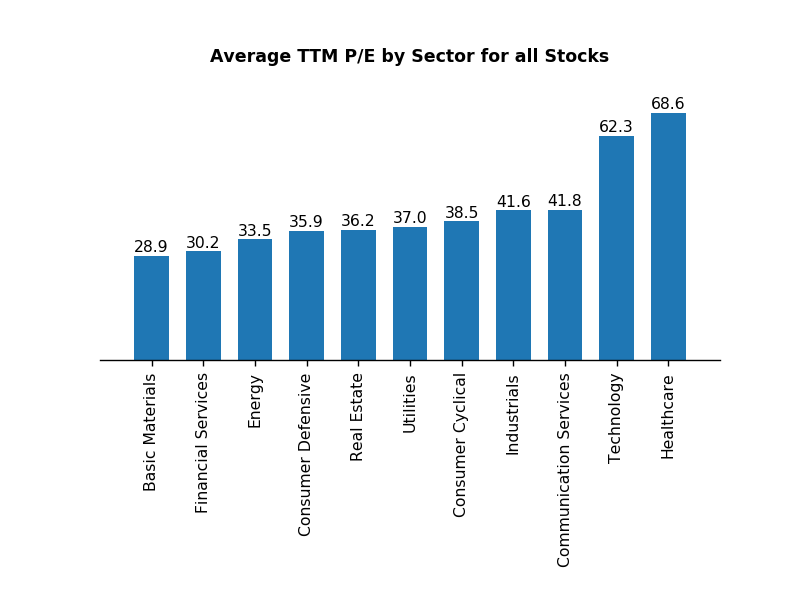

In [118]:
fig_pe, ax_pe = plt.subplots(1)
x = [x*3 for x in range(len(pe))]
y = pe.sort_values(ascending=True)
bars = ax_pe.bar(x, y, width=2)
plt.xticks(ticks=x, labels=y.index.tolist(), fontsize=9)
for tick in ax_pe.xaxis.get_ticklabels():
    tick.set_rotation(90)
plt.subplots_adjust(bottom=0.4)
plt.title('Average TTM P/E by Sector for all Stocks', fontsize=10, fontweight='bold')
plt.yticks([])
for bar in bars:
    ax_pe.text(bar.get_x()+1, bar.get_height()+1, '{:.1f}'.format(bar.get_height()), 
               color='black', ha='center', fontsize=9)
plt.axis([-3, len(x)*3, 0, 80])
ax_pe.get_children()[22].set_color(None)
ax_pe.get_children()[23].set_color(None)
ax_pe.get_children()[25].set_color(None)

*USA*

In [119]:
pe = df_valuation_mean_usa['PE_TTM']

<IPython.core.display.Javascript object>


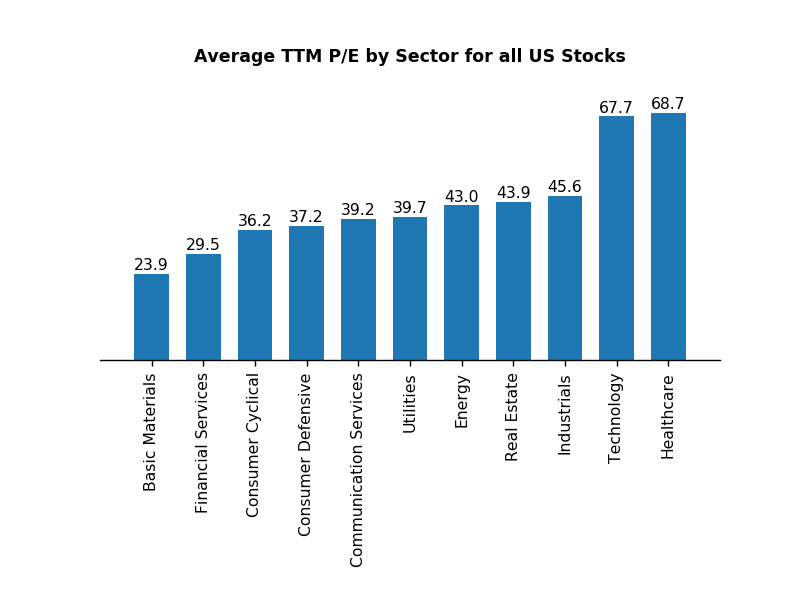

In [120]:
fig_pe, ax_pe = plt.subplots(1)
x = [x*3 for x in range(len(pe))]
y = pe.sort_values(ascending=True)
bars = ax_pe.bar(x, y, width=2)
plt.xticks(ticks=x, labels=y.index.tolist(), fontsize=9)
for tick in ax_pe.xaxis.get_ticklabels():
    tick.set_rotation(90)
plt.subplots_adjust(bottom=0.4)
plt.title('Average TTM P/E by Sector for all US Stocks', fontsize=10, fontweight='bold')
plt.yticks([])
for bar in bars:
    ax_pe.text(bar.get_x()+1, bar.get_height()+1, '{:.1f}'.format(bar.get_height()), 
               color='black', ha='center', fontsize=9)
plt.axis([-3, len(x)*3, 0, 80])
ax_pe.get_children()[22].set_color(None)
ax_pe.get_children()[23].set_color(None)
ax_pe.get_children()[25].set_color(None)

*DEU*

In [121]:
pe = df_valuation_mean_deu['PE_TTM']

<IPython.core.display.Javascript object>


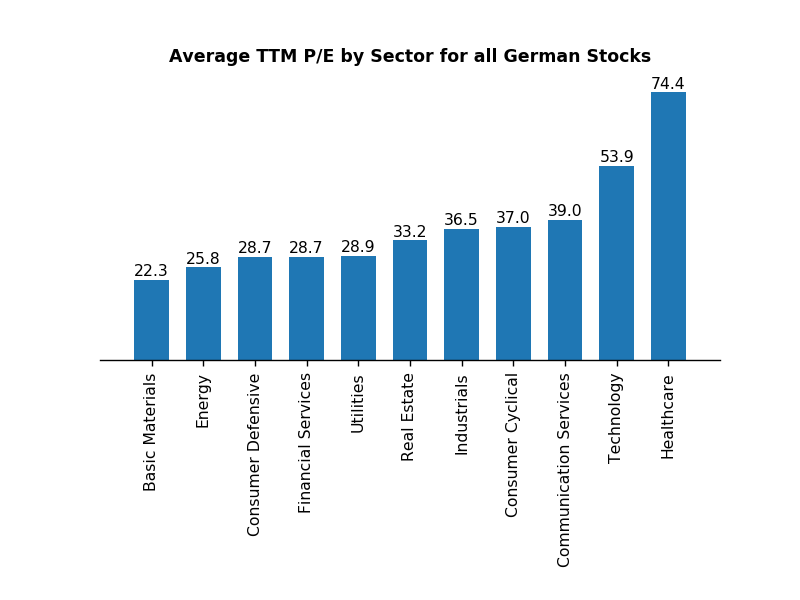

In [122]:
fig_pe, ax_pe = plt.subplots(1)
x = [x*3 for x in range(len(pe))]
y = pe.sort_values(ascending=True)
bars = ax_pe.bar(x, y, width=2)
plt.xticks(ticks=x, labels=y.index.tolist(), fontsize=9)
for tick in ax_pe.xaxis.get_ticklabels():
    tick.set_rotation(90)
plt.subplots_adjust(bottom=0.4)
plt.title('Average TTM P/E by Sector for all German Stocks', fontsize=10, fontweight='bold')
plt.yticks([])
for bar in bars:
    ax_pe.text(bar.get_x()+1, bar.get_height()+1, '{:.1f}'.format(bar.get_height()), 
               color='black', ha='center', fontsize=9)
plt.axis([-3, len(x)*3, 0, 80])
ax_pe.get_children()[22].set_color(None)
ax_pe.get_children()[23].set_color(None)
ax_pe.get_children()[25].set_color(None)

### Stocks in the Cannabis Industry
Using stocks listed on [marijuanaindex.com](http://marijuanaindex.com/stock-quotes/north-american-marijuana-index/) under North America

In [123]:
import json

with open('input/pot_stocks.json') as file:
    pot_symbols = json.loads(file.read())
    
pot_stocks = (pd.DataFrame(pot_symbols, columns=['ticker', 'country_c3'])
               .merge(df_master, how='left', on=['ticker', 'country_c3']).drop('country', axis=1)
               .rename(columns={'country_c3':'country', 'exchange_sym':'exch'}))

pot_stocks = (pot_stocks.where(((pot_stocks['country'] == 'USA') | 
                                (pot_stocks['country'] == 'CAN')) &
                               (pot_stocks['sector'] != '—'))
              .dropna(axis=0, how='all').sort_values(by='company'))

In [124]:
msg = 'Below are the {} stocks listed on marijuanaindex.com for North America.'
print(msg.format(len(pot_stocks['company'].unique())))

pot_stocks[['country', 'ticker', 'exch', 'company', 'sector', 'industry']]

Below are the 46 stocks listed on marijuanaindex.com for North America.


,country,ticker,exch,company,sector,industry
29,CAN,TGIF,XCNQ,1933 Industries Inc,Healthcare,Drug Manufacturers - Specialty & Generic
1,USA,ACRGF,PINX,Acreage Holdings Inc Ordinary Shares (Sub Voting),Healthcare,Drug Manufacturers - Specialty & Generic
2,CAN,ACRG.U,XCNQ,Acreage Holdings Inc Ordinary Shares (Sub Voting),Healthcare,Drug Manufacturers - Specialty & Generic
37,USA,APHA,XNYS,Aphria Inc,Healthcare,Drug Manufacturers - Specialty & Generic
0,CAN,ACB,XTSE,Aurora Cannabis Inc,Healthcare,Drug Manufacturers - Specialty & Generic
36,CAN,XLY,XTSX,Auxly Cannabis Group Inc,Healthcare,Drug Manufacturers - Specialty & Generic
40,USA,CVSI,PINX,CV Sciences Inc,Healthcare,Drug Manufacturers - Specialty & Generic
32,CAN,TRST,XTSE,CannTrust Holdings Inc,Healthcare,Drug Manufacturers - Specialty & Generic
4,CAN,CNNX,XCNQ,Cannex Capital Holdings Inc,Healthcare,Drug Manufacturers - Specialty & Generic
38,USA,CGC,XNYS,Canopy Growth Corp,Healthcare,Drug Manufacturers - Specialty & Generic


<a id="value"></a>
[return to the top](#top)

## Applying various criteria to filter common stocks

- **[Rule 1](#rule1): No earnings deficit (loss) for past 5 years**
- **[Rule 2](#rule2): Uniterrupted and increasing Dividends for past 5 yrs**
- **[Rule 3](#rule3): P/E Ratio of 25 or less for the past 7 yrs and less then 20 for TTM**
- **[Rule 4](#rule4): P/B Ratio of 1 or less for TTM**
- *[Rule 5](#rule5): Filter for "bargain issues"*
- *[Rule 6](#rule6): Operating Cash Flow growth for the past 7 yr*
- *[Rule 7](#rule7): Owner earnings growth rate > 6% over past 7 years*
- *[Rule 8](#rule8): Long-term debt < 50% of total capital*
- *[Rule 9](#rule9): NAV per share > Stock Price*
- *[Rule 10](#rule10): Growth Stocks as described by Benjamin Graham in _The Intelligent Investor_*
- *[Rule 11](#rule11): Positive ratio of earnings to fixed charge*
- *[Rule 12](#rule12):*
- *[Rule 13](#rule13):*
- *[Rule 14](#rule14):*
- *[Rule 15](#rule15):*
- *[Merge DataFrames](#mergerules):*
<a id="rule1"></a>

### Rule 1. No earnings deficit (loss) for past 5 or 7 years

#### 5 Years:
*a. Identify Net Income column labels in* `df_annualIS`

In [117]:
data = 'Net income'
df_labels = df_labels_aIS[df_labels_aIS['value'] == data].sort_values(by='value')
df_labels

,value
header,
label_i50,Net income
label_i70,Net income
label_i80,Net income


*b. Get column headers for 'Net income' values for the past 5 yrs*

In [118]:
i_ids = [(label[-3:] + '_') for label in df_labels.index]

def get_icols(col):
    for i_id in i_ids:
        if i_id in col:
            return True
    return False

main_cols1 = ['ticker_id', 'exchange_id', 
             'country', 'exchange_sym', 'ticker', 'company', 
             'sector', 'industry', 'stock_type', 'style', 
             'Year_Y_6', 'Year_Y_5', 'Year_Y_4', 'Year_Y_3', 'Year_Y_2', 'Year_Y_1']
data_cols = sorted(list(filter(get_icols, df_annualIS.columns)), key=lambda r: (r[-1], r[5:8]), reverse=True)
print('The following columns contain \'{}\' values:\n{}'.format(data, data_cols))

The following columns contain 'Net income' values:
['data_i80_Y_6', 'data_i70_Y_6', 'data_i50_Y_6', 'data_i80_Y_5', 'data_i70_Y_5', 'data_i50_Y_5', 'data_i80_Y_4', 'data_i70_Y_4', 'data_i50_Y_4', 'data_i80_Y_3', 'data_i70_Y_3', 'data_i50_Y_3', 'data_i80_Y_2', 'data_i70_Y_2', 'data_i50_Y_2', 'data_i80_Y_1', 'data_i70_Y_1', 'data_i50_Y_1']


*c. Create 'Net Income' DataFrame*

In [119]:
df_annualIS['Year_Y_5'] = pd.to_datetime(df_annualIS['Year_Y_5'])

In [120]:
df_netinc5 = (df_annualIS
              .where((df_annualIS['security_type'] == 'Stock') & 
                     (df_annualIS['Year_Y_5'] >= pd.to_datetime('2018-01')))
              .dropna(axis=0, how='all')
              .drop(['country'], axis=1)
              .rename(columns={'country_c3':'country'})
             )[main_cols1 + data_cols]

np_netinc = df_netinc5[data_cols].values
netinc_cols = [('Net_Income_Y' + data_cols[i * 3][-1], (i * 3, i * 3 + 1, i * 3 + 2))
               for i in range(int(len(data_cols)/3))]

vals = []
for row in np_netinc:
    row_vals = []
    for i in range(len(netinc_cols)):
        val = None
        for col in netinc_cols[i][1]:
            if not np.isnan(row[col]):
                val = row[col]
                break
        row_vals.append(val)
    vals.append(row_vals)
    
df_vals = pd.DataFrame(vals, columns=list(zip(*netinc_cols))[0])
df_netinc5 = df_netinc5[main_cols1].join(df_vals)

In [121]:
df_rule1 = df_netinc5.where((df_netinc5['Net_Income_Y6'] > 0) & 
                            ((df_netinc5['Net_Income_Y5'] > 0) | (df_netinc5['Net_Income_Y5'].isna())) & 
                            ((df_netinc5['Net_Income_Y4'] > 0) | (df_netinc5['Net_Income_Y4'].isna())) & 
                            ((df_netinc5['Net_Income_Y3'] > 0) | (df_netinc5['Net_Income_Y3'].isna())) & 
                            ((df_netinc5['Net_Income_Y2'] > 0) | (df_netinc5['Net_Income_Y2'].isna())) & 
                            ((df_netinc5['Net_Income_Y1'] > 0) | (df_netinc5['Net_Income_Y1'].isna()))
                           ).dropna(axis=0, how='all')

In [122]:
df_rule1

,ticker_id,exchange_id,country,exchange_sym,ticker,company,sector,industry,stock_type,style,...,Year_Y_4,Year_Y_3,Year_Y_2,Year_Y_1,Net_Income_Y6,Net_Income_Y5,Net_Income_Y4,Net_Income_Y3,Net_Income_Y2,Net_Income_Y1
0,1.0,374.0,USA,ARCX,OGCP,Empire State Realty OP LP Operating Partnershi...,Real Estate,REIT - Diversified,Hard Asset,Mid Core,...,2017-12,2016-12,2015-12,2014-12,1.164020e+08,1.164020e+08,1.182530e+08,1.072500e+08,7.992800e+07,7.021000e+07
1,2.0,374.0,USA,ARCX,FISK,Empire State Realty OP LP Operating Partnershi...,Real Estate,REIT - Diversified,Hard Asset,Mid Core,...,2017-12,2016-12,2015-12,2014-12,1.164020e+08,1.164020e+08,1.182530e+08,1.072500e+08,7.992800e+07,7.021000e+07
2,3.0,374.0,USA,ARCX,ESBA,Empire State Realty OP LP Operating Partnershi...,Real Estate,REIT - Diversified,Hard Asset,Mid Core,...,2017-12,2016-12,2015-12,2014-12,1.164020e+08,1.164020e+08,1.182530e+08,1.072500e+08,7.992800e+07,7.021000e+07
3,19437.0,302.0,USA,XNYS,PSB,PS Business Parks Inc,Real Estate,REIT - Diversified,Hard Asset,Mid Core,...,2017-12,2016-12,2015-12,2014-12,2.267020e+08,2.267020e+08,1.550370e+08,1.280290e+08,1.304750e+08,1.739710e+08
4,20371.0,302.0,USA,XNYS,STOR,STORE Capital Corp,Real Estate,REIT - Diversified,Hard Asset,Mid Core,...,2017-12,2016-12,2015-12,2014-12,2.169700e+08,2.169700e+08,1.620380e+08,1.233250e+08,8.377000e+07,4.813900e+07
5,16558.0,44.0,USA,XNAS,LAMR,Lamar Advertising Co Class A,Real Estate,REIT - Diversified,Hard Asset,Mid Core,...,2017-12,2016-12,2015-12,2014-12,3.052320e+08,3.052320e+08,3.176760e+08,2.988090e+08,2.625700e+08,2.535180e+08
7,19148.0,302.0,USA,XNYS,EQC,Equity Commonwealth,Real Estate,REIT - Office,Hard Asset,Mid Core,...,2017-12,2016-12,2015-12,2014-12,2.728130e+08,2.728130e+08,2.965600e+07,2.328940e+08,9.985700e+07,2.401200e+07
8,19275.0,302.0,USA,XNYS,LPT,Liberty Property Trust,Real Estate,REIT - Office,Hard Asset,Mid Core,...,2017-12,2016-12,2015-12,2014-12,4.796070e+08,4.796070e+08,2.823400e+08,3.568170e+08,2.380390e+08,2.179100e+08
9,19727.0,302.0,USA,XNYS,VNO,Vornado Realty Trust,Real Estate,REIT - Office,Hard Asset,Mid Core,...,2017-12,2016-12,2015-12,2011-12,4.499540e+08,4.499540e+08,2.274160e+08,9.069170e+08,7.604340e+08,6.623020e+08
11,19849.0,302.0,USA,XNYS,DEI,Douglas Emmett Inc,Real Estate,REIT - Office,Hard Asset,Mid Core,...,2017-12,2016-12,2015-12,2014-12,1.160860e+08,1.160860e+08,9.444300e+07,8.539700e+07,5.838400e+07,4.462100e+07


In [123]:
cols = ['country_c3', 'exchange_sym', 'ticker', 'company', 'sector', 'industry'] + \
        [col for col in df_keyratios.columns if col.startswith('i4_') or col.startswith('Y')]

df_keyratios[cols]

,country_c3,exchange_sym,ticker,company,sector,industry,i4_Y0,i4_Y1,i4_Y2,i4_Y3,...,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10
0,USA,ARCX,OGCP,Empire State Realty OP LP Operating Partnershi...,Real Estate,REIT - Diversified,NaN,NaN,57.0,49.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
1,USA,ARCX,FISK,Empire State Realty OP LP Operating Partnershi...,Real Estate,REIT - Diversified,NaN,NaN,57.0,49.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
2,USA,ARCX,ESBA,Empire State Realty OP LP Operating Partnershi...,Real Estate,REIT - Diversified,NaN,NaN,57.0,49.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
3,USA,XNYS,PSB,PS Business Parks Inc,Real Estate,REIT - Diversified,77.0,85.0,94.0,89.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
4,USA,XNYS,STOR,STORE Capital Corp,Real Estate,REIT - Diversified,NaN,NaN,NaN,8.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
5,USA,XNAS,LAMR,Lamar Advertising Co Class A,Real Estate,REIT - Diversified,-58.0,-40.0,9.0,10.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
6,USA,XNYS,ARE,Alexandria Real Estate Equities Inc,Real Estate,REIT - Office,135.0,135.0,131.0,102.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
7,USA,XNYS,EQC,Equity Commonwealth,Real Estate,REIT - Office,165.0,135.0,110.0,-95.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
8,USA,XNYS,LPT,Liberty Property Trust,Real Estate,REIT - Office,56.0,128.0,184.0,137.0,...,2010-12-01,2011-12-01,2012-12-01,2013-12-01,2014-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM
9,USA,XNYS,VNO,Vornado Realty Trust,Real Estate,REIT - Office,721.0,636.0,395.0,106.0,...,2007-12-01,2008-12-01,2009-12-01,2010-12-01,2011-12-01,2015-12-01,2016-12-01,2017-12-01,2018-12-01,TTM


[return to top of this section](#value),
[return to the top](#top)
<a id="rule2"></a>
### Rule 2. Uniterrupted and increasing *Dividends* for past 7 yrs

**a. Identify *Dividends* column label in** `df_keyratios`

In [124]:
icol = df_labels_kratios[df_labels_kratios == 'Dividends'].index[0]
icol

'i6'

**b. Get column headers for *Dividends* for the past 5 yrs**

In [125]:
main_cols2 = ['ticker_id', 'exchange_id', 
             #'country_c3', 'exchange_sym', 'ticker', 'company', 
             #'sector', 'industry', 'stock_type', 'style', 
             'Y10', 'Y9', 'Y8', 'Y7', 'Y6', 'Y5']
icols = sorted([col for col in df_keyratios.columns if icol + '_' in col], 
               key=lambda col: int(col[4:]), reverse=True)[:8]
icols

['i6_Y10', 'i6_Y9', 'i6_Y8', 'i6_Y7', 'i6_Y6', 'i6_Y5', 'i6_Y4', 'i6_Y3']

**c. Create 'Net Income' DataFrame**

In [126]:
df_rule2 = (df_keyratios
            .where((df_keyratios['security_type'] == 'Stock') & 
                   (df_keyratios['Y9'] >= pd.to_datetime('2018-01')) & 
                   (df_keyratios['i6_Y10'].notna()) & (df_keyratios['i6_Y9'].notna()) &
                   (df_keyratios['i6_Y8'].notna()) & (df_keyratios['i6_Y7'].notna()) &
                   (df_keyratios['i6_Y6'].notna()) & (df_keyratios['i6_Y5'].notna()) & 
                   (df_keyratios['i6_Y4'].notna()) & (df_keyratios['i6_Y3'].notna()) & 
                   (df_keyratios['i6_Y10'] >= df_keyratios['i6_Y9']) & 
                   (df_keyratios['i6_Y9'] >= df_keyratios['i6_Y8']) & 
                   (df_keyratios['i6_Y8'] >= df_keyratios['i6_Y7']) & 
                   (df_keyratios['i6_Y7'] >= df_keyratios['i6_Y6']) & 
                   (df_keyratios['i6_Y6'] >= df_keyratios['i6_Y5']) & 
                   (df_keyratios['i6_Y5'] >= df_keyratios['i6_Y4']) & 
                   (df_keyratios['i6_Y4'] >= df_keyratios['i6_Y3']))
            .dropna(axis=0, how='all').sort_values(by='Y9', ascending=False))[main_cols2 + icols]

df_rule2.columns = main_cols2 + [col.replace('i6', 'Dividend') for col in icols]

In [127]:
df_rule2

,ticker_id,exchange_id,Y10,Y9,Y8,Y7,Y6,Y5,Dividend_Y10,Dividend_Y9,Dividend_Y8,Dividend_Y7,Dividend_Y6,Dividend_Y5,Dividend_Y4,Dividend_Y3
59397,19619.0,302.0,TTM,2019-01-01,2018-01-01,2017-01-01,2016-01-01,2015-01-01,2.52,2.52,2.44,2.32,2.16,1.90,1.58,1.32
59362,18997.0,302.0,TTM,2019-01-01,2018-01-01,2017-01-01,2016-01-01,2015-01-01,0.40,0.40,0.34,0.28,0.26,0.24,0.22,0.20
59357,19073.0,302.0,TTM,2019-01-01,2018-01-01,2017-01-01,2016-01-01,2015-01-01,1.51,1.51,1.51,1.49,1.39,1.19,0.95,0.80
59356,19091.0,302.0,TTM,2019-01-01,2018-01-01,2017-01-01,2016-01-01,2015-01-01,1.38,1.38,1.24,1.10,1.00,0.88,0.80,0.72
59355,19276.0,302.0,TTM,2019-01-01,2018-01-01,2017-01-01,2016-01-01,2015-01-01,2.40,2.40,2.40,2.40,2.00,1.36,1.20,1.00
63356,19285.0,302.0,TTM,2019-01-01,2018-01-01,2017-01-01,2016-01-01,2015-01-01,1.85,1.85,1.58,1.33,1.07,0.87,0.70,0.62
59354,19106.0,302.0,TTM,2019-01-01,2018-01-01,2017-01-01,2016-01-01,2015-01-01,0.97,0.97,0.92,0.92,0.92,0.88,0.70,0.50
59353,18994.0,302.0,TTM,2019-01-01,2018-01-01,2017-01-01,2016-01-01,2015-01-01,0.90,0.90,0.68,0.60,0.55,0.50,0.50,0.50
59352,19393.0,302.0,TTM,2019-01-01,2018-01-01,2017-01-01,2016-01-01,2015-01-01,1.48,1.48,1.48,1.48,1.48,1.32,1.20,1.08
59351,19249.0,302.0,TTM,2019-01-01,2018-01-01,2017-01-01,2016-01-01,2015-01-01,2.44,2.44,2.20,2.00,1.80,1.56,1.40,1.28


[return to top of this section](#value),
[return to the top](#top)
<a id="rule3"></a>
### Rule 3. P/E Ratio of 25 or less for the past 7 yrs and less then 20 for TTM

In [134]:
pe_cols = [col for col in df_valuation.columns if 'PE_' in col]
pe_cols = ['ticker_id', 'exchange_id'] + [pe_cols[len(pe_cols)-i-1] for i in range(len(pe_cols))][:8]
pe_cols

['ticker_id',
 'exchange_id',
 'PE_TTM',
 'PE_2018',
 'PE_2017',
 'PE_2016',
 'PE_2015',
 'PE_2014',
 'PE_2013',
 'PE_2012']

In [140]:
df_rule3 = (df_vals[pe_cols]
            .where((df_vals['PE_TTM'] <= 20) & (df_vals['PE_2018'] <= 25) &
                   (df_vals['PE_2017'] <= 25) & (df_vals['PE_2016'] <= 25) &
                   (df_vals['PE_2015'] <= 25) & (df_vals['PE_2014'] <= 25) &
                   (df_vals['PE_2013'] <= 25) & (df_vals['PE_2012'] <= 25)).dropna(axis=0, how='all'))

In [141]:
df_rule3

,ticker_id,exchange_id,PE_TTM,PE_2018,PE_2017,PE_2016,PE_2015,PE_2014,PE_2013,PE_2012
643,644.0,1.0,14.3,15.0,15.2,15.1,13.6,17.7,11.8,10.4
700,704.0,1.0,6.4,5.4,9.0,15.5,14.5,14.7,17.1,16.2
878,885.0,1.0,15.9,16.2,20.4,21.4,18.3,15.2,14.1,14.5
888,895.0,1.0,7.5,7.3,8.2,7.2,11.7,14.9,24.3,17.8
946,954.0,1.0,5.9,4.4,14.3,9.1,3.5,6.4,4.5,5.2
1054,1063.0,17.0,5.7,4.3,9.4,11.0,6.6,6.4,6.0,12.4
1055,1063.0,141.0,5.5,4.2,8.8,10.6,6.3,6.9,6.7,13.6
1080,1087.0,1.0,4.3,4.1,7.4,5.8,4.7,5.0,6.4,6.0
1144,1152.0,1.0,11.1,12.2,12.9,13.3,18.9,8.5,4.4,4.7
1149,1158.0,1.0,15.1,10.9,16.5,15.9,16.1,15.3,13.6,8.0


[return to top of this section](#value),
[return to the top](#top)
<a id="rule4"></a>
### Rule 4. P/B Ratio of 1 or less for TTM

In [142]:
pb_cols = [col for col in df_vals.columns if 'PB_' in col]
pb_cols = [pb_cols[len(pb_cols)-i-1] for i in range(len(pb_cols))][:6]
pb_cols

['PB_TTM', 'PB_2018', 'PB_2017', 'PB_2016', 'PB_2015', 'PB_2014']

In [143]:
df_rule4 = (df_vals[['ticker_id', 'exchange_id'] + pb_cols]
            .where(df_vals['PB_TTM'] <= 1).dropna(axis=0))

In [144]:
df_rule4

,ticker_id,exchange_id,PB_TTM,PB_2018,PB_2017,PB_2016,PB_2015,PB_2014
144,139.0,1.0,0.7,0.6,0.7,0.2,0.6,0.8
148,143.0,1.0,0.1,0.1,0.3,0.6,0.2,0.5
308,302.0,1.0,0.9,1.0,3.6,-14.1,0.9,0.1
340,335.0,1.0,0.8,0.6,1.8,0.3,0.2,0.8
366,361.0,1.0,0.5,0.5,1.2,0.9,2.1,8.5
400,396.0,1.0,0.6,0.6,1.4,2.8,5.1,4.5
513,511.0,1.0,1.0,0.9,1.9,2.1,1.0,1.0
601,602.0,1.0,0.3,0.4,0.9,2.4,0.2,0.2
672,675.0,1.0,0.8,0.6,1.5,2.1,1.7,3.1
686,689.0,1.0,0.2,0.1,0.8,0.9,0.7,1.0


[return to top of this section](#value),
[return to the top](#top)
<a id="rule5"></a>
### Rule 5. Filtering for *bargain issues* as described by Benjamin Graham in *The Intelligent Investor*:

In his book, Graham defines bargain issues as common stocks where:

- $stock\ price\ < \frac{2}{3}\ net\ current\ asset\ value\ per\ share\ (NCAVPS)\$

- $net\ current\ asset\ value\ (NCAV)\ = current\ assets\ - total\ liabilities\ - preferred\ stocks\$

In [85]:
# Current Assets = g1

cols = ['ticker_id', 'exchange_id'] + [col for col in df_quarterlyBS.columns 
                                       if 'data_g1_Y' in col or 'Year_Y' in col]

In [87]:
df_master.merge(df_quarterlyBS[cols], on=['ticker_id', 'exchange_id'])

,ticker_id,exchange_id,ticker,company,exchange,exchange_sym,industry,sector,country,country_c2,...,Year_Y_1,Year_Y_2,Year_Y_3,Year_Y_4,Year_Y_5,data_g1_Y_1,data_g1_Y_2,data_g1_Y_3,data_g1_Y_4,data_g1_Y_5
0,1.0,374.0,OGCP,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,ARCX,REIT - Diversified,Real Estate,United States,US,...,1,2,3,4,5,NaN,NaN,NaN,NaN,NaN
1,2.0,374.0,FISK,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,ARCX,REIT - Diversified,Real Estate,United States,US,...,1,2,3,4,5,NaN,NaN,NaN,NaN,NaN
2,3.0,374.0,ESBA,Empire State Realty OP LP Operating Partnershi...,NYSE ARCA,ARCX,REIT - Diversified,Real Estate,United States,US,...,1,2,3,4,5,NaN,NaN,NaN,NaN,NaN
3,19437.0,302.0,PSB,PS Business Parks Inc,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Diversified,Real Estate,United States,US,...,1,2,3,4,5,NaN,NaN,NaN,NaN,NaN
4,20371.0,302.0,STOR,STORE Capital Corp,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Diversified,Real Estate,United States,US,...,1,2,3,4,5,NaN,NaN,NaN,NaN,NaN
5,16558.0,44.0,LAMR,Lamar Advertising Co Class A,NASDAQ,XNAS,REIT - Diversified,Real Estate,United States,US,...,1,2,3,4,5,NaN,NaN,NaN,NaN,NaN
6,18686.0,302.0,ARE,Alexandria Real Estate Equities Inc,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Office,Real Estate,United States,US,...,1,2,3,4,5,NaN,NaN,NaN,NaN,NaN
7,19148.0,302.0,EQC,Equity Commonwealth,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Office,Real Estate,United States,US,...,1,2,3,4,5,NaN,NaN,NaN,NaN,NaN
8,19275.0,302.0,LPT,Liberty Property Trust,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Office,Real Estate,United States,US,...,1,2,3,4,5,NaN,NaN,NaN,NaN,NaN
9,19727.0,302.0,VNO,Vornado Realty Trust,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Office,Real Estate,United States,US,...,1,2,3,4,5,NaN,NaN,NaN,NaN,NaN


[return to top of this section](#value),
[return to the top](#top)
<a id="rule6"></a>
### Rule 6. Operating Cash Flow growth for the past 7 yrs

[return to top of this section](#value),
[return to the top](#top)
<a id="rule7"></a>
### Rule 7. *Owner earnings* growth rate > 6% over past 7 years

$owner\ earning's = net\ income + amortization\ and\ depreciation\ - normal\ capital\ expenditures$

Benjamin Graham mentions in *Intelligent Investor* that, because it adjusts for entries like amortization and depreciation that do not affect the company's cash balances, *owner earnings* is a better measure to reported net income. 

[return to top of this section](#value),
[return to the top](#top)
<a id="rule8"></a>
### Rule 8. Long-term debt < 50% of total capital

[return to top of this section](#value),
[return to the top](#top)
<a id="rule9"></a>
### Rule 9. NAV per share > Stock Price

The definition of NAV as described by Graham in the Intelligent Investor

$net\ asset\ value\ (NAV)\ = total\ assets\ - intangible\ assets\ (patents,\ goodwill)\ - total\ liabilities\$

[return to top of this section](#value),
[return to the top](#top)
<a id="rule10"></a>
### Rule 10. Growth Stocks as defined in *The Intelligent Investor*

*'The term “growth stock” is applied to one which has increased its per-share earnings in the past at well above the rate for common stocks generally and is expected to continue to do so in the future. (Some authorities would say that a true growth stock should be expected at least to double its per-share earnings in ten years—i.e., to increase them at a __compounded annual rate of over 7.1%__.)'* - Benjamin Graham, *The Intelligent Investor*

$$Compounded\ Annual\ Growth\ Rate\ (CAGR)\ = \left(\frac{EV}{BV}\right)^{\frac{1}{n}}-1 > 7.1\%$$

$$EV = Ending\ value\$$

$$BV = Beginning\ value\$$

$$n = Number\ of\ periods\ (months,\ years,\ etc.)\$$

[return to top of this section](#value),
[return to the top](#top)
<a id="rule11"></a>
### Rule 11. Positive ratio of earnings to fixed charges

[return to top of this section](#value),
[return to the top](#top)
<a id="rule12"></a>
### Rule 12. 

[return to top of this section](#value),
[return to the top](#top)
<a id="rule13"></a>
### Rule 13. 

[return to top of this section](#value),
[return to the top](#top)
<a id="rule14"></a>
### Rule 14. 

[return to top of this section](#value),
[return to the top](#top)
<a id="rule15"></a>
### Rule 15. 

[return to top of this section](#value),
[return to the top](#top)
<a id="mergerules"></a>
### Merging DataFrames

In [145]:
df_rules = (df_rule1
            .merge(df_rule2, on=['ticker_id', 'exchange_id'])
            .merge(df_rule3, on=['ticker_id', 'exchange_id'])
            .merge(df_rule4, on=['ticker_id', 'exchange_id'])
           )

In [146]:
df_rules.columns.values

array(['ticker_id', 'exchange_id', 'country', 'exchange_sym', 'ticker',
       'company', 'sector', 'industry', 'stock_type', 'style', 'Year_Y_6',
       'Year_Y_5', 'Year_Y_4', 'Year_Y_3', 'Year_Y_2', 'Year_Y_1',
       'Net_Income_Y6', 'Net_Income_Y5', 'Net_Income_Y4', 'Net_Income_Y3',
       'Net_Income_Y2', 'Net_Income_Y1', 'Y10', 'Y9', 'Y8', 'Y7', 'Y6',
       'Y5', 'Dividend_Y10', 'Dividend_Y9', 'Dividend_Y8', 'Dividend_Y7',
       'Dividend_Y6', 'Dividend_Y5', 'Dividend_Y4', 'Dividend_Y3',
       'PE_TTM', 'PE_2018', 'PE_2017', 'PE_2016', 'PE_2015', 'PE_2014',
       'PE_2013', 'PE_2012', 'PB_TTM', 'PB_2018', 'PB_2017', 'PB_2016',
       'PB_2015', 'PB_2014'], dtype=object)

In [160]:
dfr = (df_rules
       .where(df_rules['country'] == 'USA')
       .groupby(['country', 'exchange_sym', 'ticker', 'company', 'sector', 'industry'])
       .mean()
       .sort_values(by='exchange_sym', ascending=True)
      )

In [161]:
dfr

ticker_id  \
country exchange_sym ticker company                                            sector             industry                                
USA     PINX         BMWYY  Bayerische Motoren Werke AG ADR                    Consumer Cyclical  Auto Manufacturers            11637.0   
                     CCOHF  China State Construction International Holdings... Industrials        Engineering & Construction     9413.0   
                     CLLDY  CapitaLand Ltd ADR                                 Real Estate        Real Estate - General          7082.0   
                     CWYCY  China Railway Construction Corp Ltd ADR            Industrials        Engineering & Construction    11682.0   
                     HNGKY  Hongkong Land Holdings Ltd ADR                     Real Estate        Real Estate - General          8462.0   
                     ISBA   Isabella Bank Corp                                 Financial Services Banks - Regional - US          6100.0   
                     NBNKF  Nordea Bank Abp                                    Financial Services Banks - Regional - Europe      9351.0   
                     NSANY  Nissan Motor Co Ltd ADR                            Consumer Cyclical  Auto Manufacturers             6268.0   
                     QNTO   Quaint Oak Bancorp Inc                             Financial Services Banks - Regional - US          9752.0   
        XASE         DIT    Amcon Distributing Co                              Consumer Defensive Food Distribution             15692.0   
        XNAS         UMPQ   Umpqua Holdings Corp                               Financial Services Banks - Regional - US         17076.0   
                     LCNB   LCNB Corp                                          Financial Services Banks - Regional - US         16548.0   
                     HOPE   Hope Bancorp Inc                                   Financial Services Banks - Regional - US         16671.0   
                     FBIZ   First Business Financial Services Inc              Financial Services Banks - Regional - US         16337.0   
                     ARCC   Ares Capital Corp                                  Financial Services Asset Management              16012.0   
                     HNNA   Hennessy Advisors Inc                              Financial Services Asset Management              16436.0   
        XNYS         IVZ    Invesco Ltd                                        Financial Services Asset Management              18718.0   
                     AGO    Assured Guaranty Ltd                               Financial Services Insurance - Specialty         18744.0   
                     BHLB   Berkshire Hills Bancorp Inc                        Financial Services Banks - Regional - US         18793.0   
                     COF    Capital One Financial Corp                         Financial Services Credit Services               18860.0   
                     F      Ford Motor Co                                      Consumer Cyclical  Auto Manufacturers            19092.0   
                     FNB    F N B Corp                                         Financial Services Banks - Regional - US         19062.0   
                     GS     Goldman Sachs Group Inc                            Financial Services Capital Markets               19127.0   
                     NNI    Nelnet Inc Class A                                 Financial Services Credit Services               19376.0   

                                                                                                                              exchange_id  \
country exchange_sym ticker company                                            sector             industry                                  
USA     PINX         BMWYY  Bayerische Motoren Werke AG ADR                    Consumer Cyclical  Auto Manufacturers                 25.0   
                     CCOHF  China State Construction International Holdings... Industria

In [154]:
dfr.columns

Index(['ticker_id', 'exchange_id', 'Net_Income_Y6', 'Net_Income_Y5',
       'Net_Income_Y4', 'Net_Income_Y3', 'Net_Income_Y2', 'Net_Income_Y1',
       'Dividend_Y10', 'Dividend_Y9', 'Dividend_Y8', 'Dividend_Y7',
       'Dividend_Y6', 'Dividend_Y5', 'Dividend_Y4', 'Dividend_Y3', 'PE_TTM',
       'PE_2018', 'PE_2017', 'PE_2016', 'PE_2015', 'PE_2014', 'PE_2013',
       'PE_2012', 'PB_TTM', 'PB_2018', 'PB_2017', 'PB_2016', 'PB_2015',
       'PB_2014'],
      dtype='object')

<a id="additional"></a>
[return to the top](#top)

## Additional sample / test code

In [164]:
(df_master
 .where(df_master['avevol'] > 1000000).dropna(axis=0, how='all')
)

,ticker_id,exchange_id,ticker,company,exchange,exchange_sym,industry,sector,country,country_c2,...,aprvol,avevol,Forward_PE,pb,ps,pc,currency,currency_code,fy_end,updated_date
4,20371.0,302.0,STOR,STORE Capital Corp,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Diversified,Real Estate,United States,US,...,1.500000e+07,1.700000e+07,NaN,1.9,12.7,17.5,United States Dollar,USD,2019-12-31,2019-04-08
14,19993.0,302.0,PEB,Pebblebrook Hotel Trust,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Hotel & Motel,Real Estate,United States,US,...,1.100000e+07,1.200000e+07,36.8,1.1,2.9,17.5,United States Dollar,USD,2019-12-31,2019-04-08
15,18925.0,302.0,NNN,National Retail Properties Inc,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Retail,Real Estate,United States,US,...,6.255050e+05,1.100000e+07,NaN,2.5,13.5,17.8,United States Dollar,USD,2019-12-31,2019-04-08
20,18726.0,302.0,AIV,Apartment Investment & Management Co,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Residential,Real Estate,United States,US,...,6.082250e+05,1.300000e+07,181.8,4.8,7.9,19.4,United States Dollar,USD,2019-12-31,2019-04-08
24,19694.0,302.0,UDR,UDR Inc,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Residential,Real Estate,United States,US,...,1.100000e+07,1.500000e+07,NaN,4.5,11.7,21.9,United States Dollar,USD,2019-12-31,2019-04-08
25,20221.0,302.0,AMH,American Homes 4 Rent Class A,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Residential,Real Estate,United States,US,...,9.166240e+05,2.000000e+07,20.6,1.3,6.3,16.5,United States Dollar,USD,2019-12-31,2019-04-08
26,20509.0,302.0,INVH,Invitation Homes Inc,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Residential,Real Estate,United States,US,...,2.700000e+07,3.400000e+07,19.8,1.6,7.4,22.7,United States Dollar,USD,2019-12-31,2019-04-08
31,19677.0,302.0,CUBE,CubeSmart,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Industrial,Real Estate,United States,US,...,8.983220e+05,1.400000e+07,NaN,3.5,10.0,19.6,United States Dollar,USD,2019-12-31,2019-04-08
32,19013.0,302.0,DRE,Duke Realty Corp,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Industrial,Real Estate,United States,US,...,1.700000e+07,2.100000e+07,57.1,2.4,11.7,22.9,United States Dollar,USD,2019-12-31,2019-04-08
34,19162.0,302.0,HCP,HCP Inc,"NEW YORK STOCK EXCHANGE, INC.",XNYS,REIT - Healthcare Facilities,Real Estate,United States,US,...,2.600000e+07,3.200000e+07,69.4,2.5,8.3,17.5,United States Dollar,USD,2019-12-31,2019-04-08


In [16]:
df = None # Set df variable to none to close db connection 

Database connection for file db/mstables2.sqlite closed.
